In [309]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import random
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
import nltk
import re
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout
from keras.callbacks import ModelCheckpoint


In [272]:
def load_dataset(filename):
    df = pd.read_csv(filename, encoding = "latin1", names = ["Sentence", "Intent"])
    print(df.head())
    intent = df["Intent"]
    unique_intent = list(set(intent))
    sentences = list(df["Sentence"])
  
    return (intent, unique_intent, sentences)
  


In [273]:
intent, unique_intent, sentences = load_dataset("data.csv")

                      Sentence Intent
0          What does that cost  price
1  What's the price of <Item>?  price
2          How much is <item>?  price
3              Cost of <Item>?  price
4       What does <Item> cost?  price


In [274]:
print(sentences[:5])

['What does that cost', "What's the price of <Item>?", 'How much is <item>?', 'Cost of <Item>?', 'What does <Item> cost?']


In [275]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maxlengdell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/maxlengdell/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [276]:
#define stemmer
stemmer = LancasterStemmer()

In [277]:
def cleaning(sentences):
    words = []
    for s in sentences:
        clean = re.sub(r'[^ a-z A-Z 0-9]', " ", s)
        w = word_tokenize(clean)
        #stemming
        words.append([i.lower() for i in w])
    
    return words  

In [278]:
cleaned_words = cleaning(sentences)
print(len(cleaned_words))
print(cleaned_words[:2])  
  


42
[['what', 'does', 'that', 'cost'], ['what', 's', 'the', 'price', 'of', 'item']]


In [279]:
def create_tokenizer(words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'):
    token = Tokenizer(filters = filters)
    token.fit_on_texts(words)
    print(token)
    return token

In [280]:
def max_length(words):
    return(len(max(words, key = len)))
  

In [281]:
word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(word_tokenizer.word_index) + 1
max_length = max_length(cleaned_words)

print("Vocab Size = %d and Maximum length = %d" % (vocab_size, max_length))

Vocab Size = 47 and Maximum length = 6


In [282]:
def encoding_doc(token, words):
    return(token.texts_to_sequences(words))

In [283]:
encoded_doc = encoding_doc(word_tokenizer, cleaned_words)
#print(encoded_doc)

In [284]:
def padding_doc(encoded_doc, max_length):
    return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

In [285]:
padded_doc = padding_doc(encoded_doc, max_length)

In [286]:
padded_doc[:5]

array([[ 3, 18, 29, 10,  0,  0],
       [ 3, 30, 31, 19,  5,  1],
       [11, 20, 32,  1,  0,  0],
       [10,  5,  1,  0,  0,  0],
       [ 3, 18,  1, 10,  0,  0]], dtype=int32)

In [287]:
print("Shape of padded docs = ",padded_doc.shape)

Shape of padded docs =  (42, 6)


In [288]:
#tokenizer with filter changed
output_tokenizer = create_tokenizer(unique_intent, filters = '!"#$%&()*+,-/:;<=>?@[\]^`{|}~')


In [289]:
output_tokenizer.word_index

{'common': 1, 'order': 2, 'price': 3, 'balance': 4}

In [290]:
encoded_output = encoding_doc(output_tokenizer, intent)

In [291]:
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)

In [292]:
encoded_output.shape

(42, 1)

In [293]:
def one_hot(encode):
    o = OneHotEncoder(sparse = False)
    return(o.fit_transform(encode))

In [294]:
output_one_hot = one_hot(encoded_output)

In [295]:
output_one_hot.shape

(42, 4)

In [296]:
from sklearn.model_selection import train_test_split

In [297]:
train_X, val_X, train_Y, val_Y = train_test_split(padded_doc, output_one_hot, shuffle = True, test_size = 0.2)


In [298]:
print("Shape of train_X = %s and train_Y = %s" % (train_X.shape, train_Y.shape))
print("Shape of val_X = %s and val_Y = %s" % (val_X.shape, val_Y.shape))

Shape of train_X = (33, 6) and train_Y = (33, 4)
Shape of val_X = (9, 6) and val_Y = (9, 4)


In [299]:
def create_model(vocab_size, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = False))
    model.add(Bidirectional(LSTM(128)))
#   model.add(LSTM(128))
    model.add(Dense(32, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation = "softmax"))
  
    return model





In [300]:
model = create_model(vocab_size, max_length)

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 6, 128)            6016      
_________________________________________________________________
bidirectional_8 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_15 (Dense)             (None, 32)                8224      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 4)                 132       
Total params: 277,540
Trainable params: 271,524
Non-trainable params: 6,016
_________________________________________________________________


In [301]:
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(train_X, train_Y, epochs = 150, batch_size = 32, validation_data = (val_X, val_Y), callbacks = [checkpoint])

Train on 33 samples, validate on 9 samples
Epoch 1/150
33/33 [==============================] - 1s 39ms/step - loss: 1.3859 - accuracy: 0.2121 - val_loss: 1.3847 - val_accuracy: 0.4444

Epoch 00001: val_loss improved from inf to 1.38474, saving model to model.h5
Epoch 2/150
33/33 [==============================] - 0s 518us/step - loss: 1.3787 - accuracy: 0.4848 - val_loss: 1.3839 - val_accuracy: 0.2222

Epoch 00002: val_loss improved from 1.38474 to 1.38395, saving model to model.h5
Epoch 3/150
33/33 [==============================] - 0s 538us/step - loss: 1.3755 - accuracy: 0.5455 - val_loss: 1.3798 - val_accuracy: 0.4444

Epoch 00003: val_loss improved from 1.38395 to 1.37983, saving model to model.h5
Epoch 4/150
33/33 [==============================] - 0s 543us/step - loss: 1.3747 - accuracy: 0.5455 - val_loss: 1.3767 - val_accuracy: 0.4444

Epoch 00004: val_loss improved from 1.37983 to 1.37670, saving model to model.h5
Epoch 5/150
33/33 [==============================] - 0s 581us/

33/33 [==============================] - 0s 562us/step - loss: 1.0684 - accuracy: 0.5455 - val_loss: 1.2034 - val_accuracy: 0.6667

Epoch 00040: val_loss did not improve from 1.19056
Epoch 41/150
33/33 [==============================] - 0s 532us/step - loss: 1.0354 - accuracy: 0.6970 - val_loss: 1.2059 - val_accuracy: 0.6667

Epoch 00041: val_loss did not improve from 1.19056
Epoch 42/150
33/33 [==============================] - 0s 527us/step - loss: 0.9451 - accuracy: 0.6970 - val_loss: 1.2062 - val_accuracy: 0.5556

Epoch 00042: val_loss did not improve from 1.19056
Epoch 43/150
33/33 [==============================] - 0s 561us/step - loss: 0.9639 - accuracy: 0.6667 - val_loss: 1.1909 - val_accuracy: 0.5556

Epoch 00043: val_loss did not improve from 1.19056
Epoch 44/150
33/33 [==============================] - 0s 561us/step - loss: 0.9514 - accuracy: 0.6364 - val_loss: 1.1607 - val_accuracy: 0.6667

Epoch 00044: val_loss improved from 1.19056 to 1.16072, saving model to model.h5
Epo

33/33 [==============================] - 0s 580us/step - loss: 0.2756 - accuracy: 0.9091 - val_loss: 0.2796 - val_accuracy: 1.0000

Epoch 00117: val_loss improved from 0.28260 to 0.27963, saving model to model.h5
Epoch 118/150
33/33 [==============================] - 0s 533us/step - loss: 0.3166 - accuracy: 0.8788 - val_loss: 0.2808 - val_accuracy: 0.8889

Epoch 00118: val_loss did not improve from 0.27963
Epoch 119/150
33/33 [==============================] - 0s 562us/step - loss: 0.2802 - accuracy: 0.9091 - val_loss: 0.2794 - val_accuracy: 0.8889

Epoch 00119: val_loss improved from 0.27963 to 0.27935, saving model to model.h5
Epoch 120/150
33/33 [==============================] - 0s 555us/step - loss: 0.2139 - accuracy: 0.9091 - val_loss: 0.2742 - val_accuracy: 0.8889

Epoch 00120: val_loss improved from 0.27935 to 0.27418, saving model to model.h5
Epoch 121/150
33/33 [==============================] - 0s 575us/step - loss: 0.2253 - accuracy: 0.8788 - val_loss: 0.2667 - val_accuracy

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


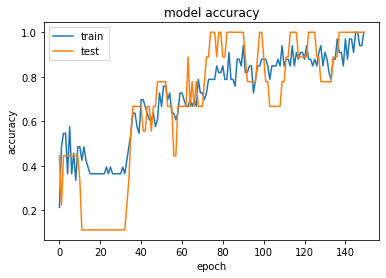

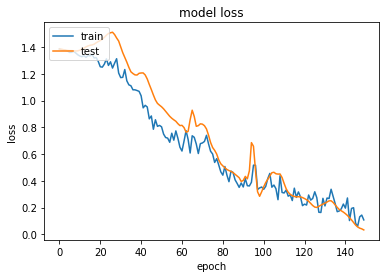

In [302]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [303]:
 model = load_model("model.h5")

In [304]:
def predictions(text):
    clean = re.sub(r'[^ a-z A-Z 0-9]', " ", text)
    test_word = word_tokenize(clean)
    test_word = [w.lower() for w in test_word]
    test_ls = word_tokenizer.texts_to_sequences(test_word)
    print(test_word)
    #Check for unknown words
    if [] in test_ls:
        test_ls = list(filter(None, test_ls))
    
    test_ls = np.array(test_ls).reshape(1, len(test_ls))
 
    x = padding_doc(test_ls, max_length)
  
    pred = model.predict_proba(x)
  
  
    return pred


  

In [225]:
def get_final_output(pred, classes):
    predictions = pred[0]
 
    classes = np.array(classes)
    ids = np.argsort(-predictions)
    classes = classes[ids]
    predictions = -np.sort(-predictions)
 
    for i in range(pred.shape[1]):
        print("%s has confidence = %s" % (classes[i], (predictions[i])))



In [158]:
text = "How much does it cost?"
pred = predictions(text)
get_final_output(pred, unique_intent)

['how', 'much', 'does', 'it', 'cost']
price has confidence = 0.77760005
balance has confidence = 0.21339433
common has confidence = 0.005277448
order has confidence = 0.003728156


In [338]:
opening_lines = ['Hello, what can I help you with?',
                'How can I help you?',
                'Whats on your mind today?']

def randomOpening():
    index = random.randint(0,len(opening_lines)-1)
    print(opening_lines[index])



Hello, what can I help you with?


In [ ]:
def cli():
    while True:
        randomOpening()
        user_input = input("Ask the chatbot something: ")
        print(user_input)
        if(user_input=="quit"):
            break
        else:
            pred = predictions(user_input)
            print(pred)
            get_final_output(pred, unique_intent)

        
cli()

Hello, what can I help you with?
Ask the chatbot something: how much does a pair of shoes cost?
how much does a pair of shoes cost?
['how', 'much', 'does', 'a', 'pair', 'of', 'shoes', 'cost']
[[0.00402675 0.00409865 0.91958594 0.07228872]]
price has confidence = 0.91958594
balance has confidence = 0.07228872
order has confidence = 0.0040986524
common has confidence = 0.0040267515
How can I help you?
